In [1]:
import numpy as np 
import pandas as pd
import tensorflow as tf 

In [2]:
from keras.layers import LSTM, Dense, Dropout, GRU 
from keras.models import Sequential
from keras.losses import MeanSquaredError
from keras.metrics import MeanAbsoluteError
from sklearn.preprocessing import StandardScaler
from keras.optimizers import Adam
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping

In [3]:
df = pd.read_csv('./jena_climate_2009_2016.csv')

In [4]:
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


In [5]:
df.columns

Index(['Date Time', 'p (mbar)', 'T (degC)', 'Tpot (K)', 'Tdew (degC)',
       'rh (%)', 'VPmax (mbar)', 'VPact (mbar)', 'VPdef (mbar)', 'sh (g/kg)',
       'H2OC (mmol/mol)', 'rho (g/m**3)', 'wv (m/s)', 'max. wv (m/s)',
       'wd (deg)'],
      dtype='object')

- Set `Date Time` to index
- Remove `Tpot (K)` as it is the same as `T (degC)`
- Remove `VPact (mbar)`, `VPdef (mbar)`, `rho (g/m**3)`, `max. wv (m/s)`
- Resample data to have daily average values
- look for missing data before and after resampling 

In [6]:
df['Date Time'] = pd.to_datetime(df['Date Time'], dayfirst=True)

In [7]:
df.set_index('Date Time', inplace=True)
df_daily = df.resample('D').mean()
df_input = df_daily[['T (degC)', 'p (mbar)' ,'Tdew (degC)', 'rh (%)',
       'VPmax (mbar)', 'sh (g/kg)',
       'H2OC (mmol/mol)', 'wv (m/s)']]

In [10]:
# check for missing values in original df
print(df.isna().sum())
print("+++++++++++++++++++++++++++++++++")
# check for missing values after resampling
print(df_input.isna().sum())

p (mbar)           0
T (degC)           0
Tpot (K)           0
Tdew (degC)        0
rh (%)             0
VPmax (mbar)       0
VPact (mbar)       0
VPdef (mbar)       0
sh (g/kg)          0
H2OC (mmol/mol)    0
rho (g/m**3)       0
wv (m/s)           0
max. wv (m/s)      0
wd (deg)           0
dtype: int64
+++++++++++++++++++++++++++++++++
T (degC)           2
p (mbar)           2
Tdew (degC)        2
rh (%)             2
VPmax (mbar)       2
sh (g/kg)          2
H2OC (mmol/mol)    2
wv (m/s)           2
dtype: int64


- There are missing values in the resampled df and not in the original
- this means that there are days for which there were no recordings 

In [11]:
# finding the days with missing data

missing_values = df_input.isna().any(axis=1)
missing_index = missing_values[missing_values].index
missing_index

DatetimeIndex(['2016-10-26', '2016-10-27'], dtype='datetime64[ns]', name='Date Time', freq='D')

In [12]:
# Fill in the missing values with interpolation
df_input = df_input.interpolate(method='linear')

- plot the Temperature `T (degC)`
- We see the expected seasonality for temperature data

<Axes: title={'center': 'Temperature °C'}, xlabel='Date Time', ylabel='°C'>

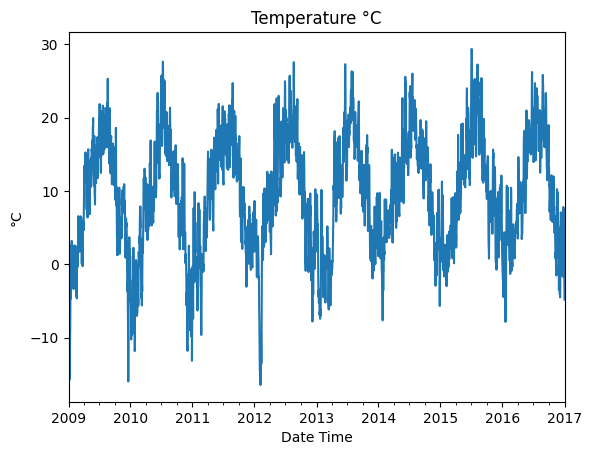

In [13]:
df_input['T (degC)'].plot(title="Temperature °C", ylabel="°C")

- extract dates for plotting later
- rescale the data 
- Setup the data:
    - We will be using 10 days of data to predict the next day
    - Then we will shift the window

In [14]:
scaler = StandardScaler()
input_scaled = scaler.fit_transform(df_input)

In [15]:
train_dates = df_input.index

In [16]:
n_future = 1
n_past = 10

In [17]:
X_train = []
y_train = []

In [18]:
for i in range(n_past, len(input_scaled) - n_future + 1):
    X_train.append(input_scaled[i - n_past:i, 0:df_input.shape[1]])
    y_train.append(input_scaled[i + n_future - 1 :i + n_future, 0])

X_train = np.array(X_train)
y_train = np.array(y_train)

print(X_train.shape)
print(y_train.shape)

(2913, 10, 8)
(2913, 1)


- setup `EarlyStopping` callback
- setup a model architecture with LSTM layers
- setup a model architecture with GRU layers
- fit the models

In [19]:
callback = EarlyStopping(monitor='val_loss',
                         patience=5,
                         mode='min')

In [20]:
# LSTM model 

model1 = Sequential()
model1.add(LSTM(128, input_shape=(10, 8), return_sequences=True))
model1.add(LSTM(128, return_sequences=True))
model1.add(Dropout(0.3))
model1.add(LSTM(64, return_sequences=False))
model1.add(Dropout(0.3))
model1.add(Dense(1))

model1.compile(optimizer=Adam(learning_rate=1e-4), loss='mae')
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 128)           70144     
                                                                 
 lstm_1 (LSTM)               (None, 10, 128)           131584    
                                                                 
 dropout (Dropout)           (None, 10, 128)           0         
                                                                 
 lstm_2 (LSTM)               (None, 64)                49408     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 251,201
Trainable params: 251,201
Non-trai

In [22]:
# GRU model
model2 = Sequential()
model2.add(GRU(128, activation='relu', dropout=0.2, recurrent_dropout=0.2, input_shape=(None, X_train.shape[2])))
model2.add(Dense(1))

model2.compile(optimizer=Adam(learning_rate=1e-4), loss='mae')
model2.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_1 (GRU)                 (None, 128)               52992     
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 53,121
Trainable params: 53,121
Non-trainable params: 0
_________________________________________________________________


In [23]:
# fit model 1

history1 = model1.fit(X_train, y_train,
                      epochs=50,
                      batch_size=32,
                      validation_split=0.2,
                      callbacks=callback)

Epoch 1/50
73/73 [==============================] - 10s 23ms/step - loss: 0.4213 - val_loss: 0.2677
Epoch 2/50
73/73 [==============================] - 1s 10ms/step - loss: 0.2845 - val_loss: 0.2394
Epoch 3/50
73/73 [==============================] - 1s 10ms/step - loss: 0.2811 - val_loss: 0.3180
Epoch 4/50
73/73 [==============================] - 1s 10ms/step - loss: 0.2850 - val_loss: 0.2967
Epoch 5/50
73/73 [==============================] - 1s 10ms/step - loss: 0.2713 - val_loss: 0.2478
Epoch 6/50
73/73 [==============================] - 1s 10ms/step - loss: 0.2554 - val_loss: 0.2497
Epoch 7/50
73/73 [==============================] - 1s 10ms/step - loss: 0.2625 - val_loss: 0.2755


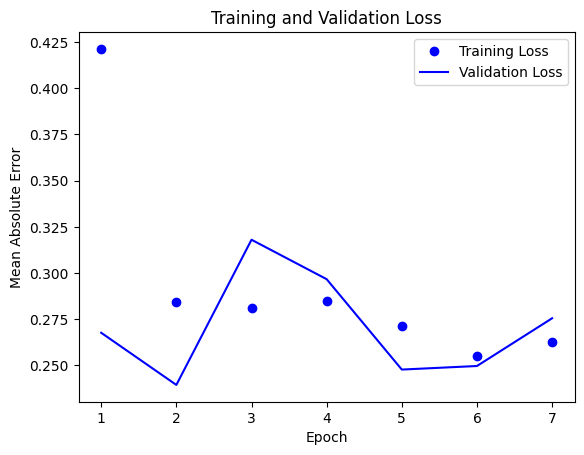

In [27]:
import matplotlib.pyplot as plt 

loss = history1.history['loss']
val_loss = history1.history['val_loss']

epochs = range(1, 8)

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b-', label='Validation Loss')
plt.title("Training and Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.show()


- The model does not perform well with minimum val loss at 0.2478 which is about 11 degrees
- We now try the GRU model

In [28]:
history2 = model2.fit(X_train, y_train,
                      epochs=50,
                      batch_size=32,
                      validation_split=0.2,
                      callbacks=callback)

Epoch 1/50
73/73 [==============================] - 5s 42ms/step - loss: 0.6199 - val_loss: 0.3943
Epoch 2/50
73/73 [==============================] - 3s 38ms/step - loss: 0.3437 - val_loss: 0.3121
Epoch 3/50
73/73 [==============================] - 3s 41ms/step - loss: 0.3121 - val_loss: 0.3023
Epoch 4/50
73/73 [==============================] - 3s 42ms/step - loss: 0.3028 - val_loss: 0.2938
Epoch 5/50
73/73 [==============================] - 3s 42ms/step - loss: 0.2979 - val_loss: 0.2877
Epoch 6/50
73/73 [==============================] - 3s 41ms/step - loss: 0.2940 - val_loss: 0.2821
Epoch 7/50
73/73 [==============================] - 3s 41ms/step - loss: 0.2847 - val_loss: 0.2780
Epoch 8/50
73/73 [==============================] - 3s 42ms/step - loss: 0.2867 - val_loss: 0.2735
Epoch 9/50
73/73 [==============================] - 3s 41ms/step - loss: 0.2827 - val_loss: 0.2718
Epoch 10/50
73/73 [==============================] - 3s 40ms/step - loss: 0.2865 - val_loss: 0.2690
Epoch 11/

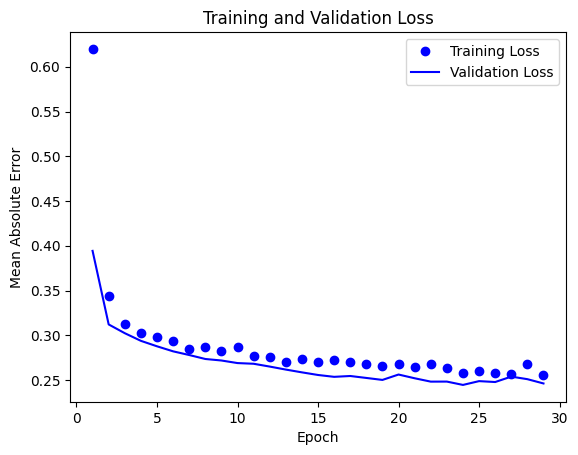

In [30]:
loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs = range(1, 30)

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b-', label='Validation Loss')
plt.title("Training and Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.show()

- A slight and not significant improvement on the LSTM.
- Minimum val loss of 0.2446 which is also about 11 degrees

### Forecasting

- forecats the next 2 years
- plot the original data along with the forecasts

In [31]:
future = 730

forecast_dates = pd.date_range(list(train_dates)[-1], periods=future, freq='1d').tolist()

forecast = model2.predict(X_train[-future:])

# Need 8 columns for inverse scaling
forecast_copies = np.repeat(forecast, 8, axis=-1)

y_pred_future = scaler.inverse_transform(forecast_copies)[:,0]

fore_dates = [d.date() for d in forecast_dates]

df_forecast = pd.DataFrame({'Date': np.array(fore_dates), 'T (degC)': y_pred_future})

# set date to datetime
df_forecast['Date'] = pd.to_datetime(df_forecast['Date'])
df_forecast.set_index('Date', inplace=True)

# create a series with original data 
original = df_input['T (degC)']

23/23 [==============================] - 0s 9ms/step


Text(0, 0.5, '°C')

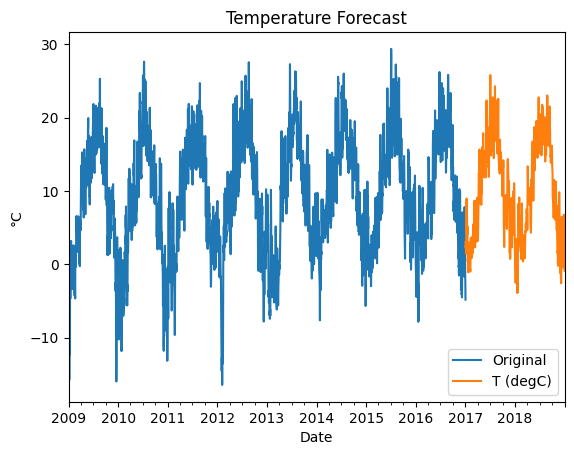

In [34]:
ax = original.plot(label='Original')
df_forecast.plot(label='Forecast', ax=ax)
ax.legend()
ax.set_title('Temperature Forecast')
ax.set_ylabel('°C')